# QamomileにおけるQuriPartsTranspilerの使用方法
このチュートリアルでは、QamomileにおけるQuriPartsTranspilerの使用方法を示し、ユーザーが効果的に活用できるように主要な例を紹介します。

## ハミルトニアンをQuriParts形式に変換する

まず、テスト用のハミルトニアンを定義し、それをQuriParts互換の形式に変換するためにトランスパイラを使用します。このステップでは、独自ライブラリで定義されたハミルトニアンが、QuriPartsで認識される演算子にどれほどスムーズに変換されるかを示します。

In [1]:
from typing import Sequence

import jijmodeling as jm
import networkx as nx
import numpy as np
from quri_parts.core.state import quantum_state, apply_circuit
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator
import matplotlib.pyplot as plt
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from scipy.optimize import minimize

import qamomile
from qamomile.quri_parts.transpiler import QuriPartsTranspiler
from qamomile.core.operator import Hamiltonian, Pauli, X, Y, Z
from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.circuit import (
    QuantumCircuit,
    SingleQubitGate,
    TwoQubitGate,
    ParametricSingleQubitGate,
    ParametricTwoQubitGate,
    SingleQubitGateType,
    TwoQubitGateType,
    ParametricSingleQubitGateType,
    ParametricTwoQubitGateType,
    Parameter
)
from qamomile.core.circuit.drawer import plot_quantum_circuit

このコードスニペットでは、さまざまなパウリ演算子（X, Y, Z）を用いてカスタム定義されたハミルトニアンから始め、`QuriPartsTranspiler`を使用してQuriPartsに適した形式へ変換します。`quriParts_hamiltonian`を出力することで、変換が正しく行われたかを確認できます。

In [2]:
hamiltonian = Hamiltonian()
hamiltonian += X(0)*Z(1)
hamiltonian += Y(0)*Y(1)*Z(2)*X(3)*X(4)

transpiler = QuriPartsTranspiler()
quriParts_hamiltonian = transpiler.transpile_hamiltonian(hamiltonian)

quriParts_hamiltonian

{frozenset({(0, <SinglePauli.X: 1>), (1, <SinglePauli.Z: 3>)}): 1.0,
 frozenset({(0, <SinglePauli.Y: 2>),
            (1, <SinglePauli.Y: 2>),
            (2, <SinglePauli.Z: 3>),
            (3, <SinglePauli.X: 1>),
            (4, <SinglePauli.X: 1>)}): 1.0}

## パラメータ化された量子回路の構築

次に、QamomileCircuitを使ってパラメータ化された量子回路を構築します。この回路には、単一量子ビットの回転ゲート（例：rx、ry、rz）と制御付きバージョン（crx、crz、cry）、さらに二量子ビットのエンタングルメントゲート（rxx、ryy、rzz）を含めます。パラメータ（theta、beta、gamma）によって、柔軟な変分的な調整が可能になります。

In [3]:
qc = QamomileCircuit(3)
theta = Parameter("theta")
beta = Parameter("beta")
gamma = Parameter("gamma")

qc.rx(theta, 0)
qc.ry(beta, 1)
qc.rz(gamma, 2)
qc.rxx(gamma, 0 ,1)
qc.ryy(theta, 1 ,2)
qc.rzz(beta, 2 ,0)

transpiler = QuriPartsTranspiler()
qp_circuit = transpiler.transpile_circuit(qc)

## MaxCut問題の定式化と量子形式への変換

このセクションでは、古典的な最適化問題であるMaxCutを取り上げ、それをイジング形式のハミルトニアンにエンコードする方法を示します。その後、QAOAスタイルのアンザッツ回路を構築し、それを実行・最適化することでMaxCutのインスタンスを解くことを目指します。

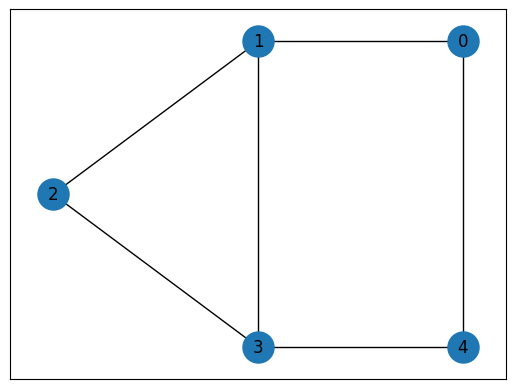

In [4]:
def maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem

def maxcut_instance():
    # MaxCutインスタンスのために簡単なグラフを構築します。
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3, 4])
    G.add_edges_from([(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])
    E = [list(edge) for edge in G.edges]
    instance_data = {"V": G.number_of_nodes(), "E": E}
    pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
    nx.draw_networkx(G, pos, node_size=500)
    return instance_data

problem = maxcut_problem()
instance_data = maxcut_instance()
interpreter = jm.Interpreter(instance_data)
compiled_instance = interpreter.eval_problem(problem)

# コンパイルした問題をQAOA形式へ変換する
qaoa_converter = qamomile.core.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode()

p = 5
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

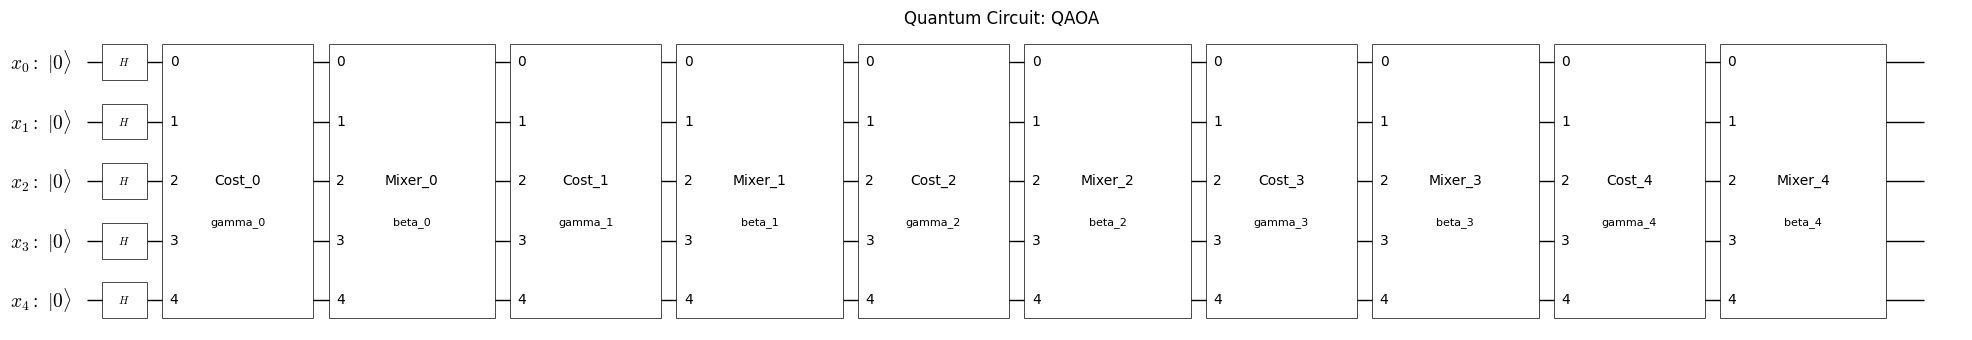

In [5]:
plot_quantum_circuit(qaoa_circuit)

私たちは現在、MaxCut問題をQAOAのようなアルゴリズムに適したコストハミルトニアンに変換しました。パラメータ`p`は、問題ハミルトニアンとミキサーハミルトニアンの層の数を決定します。各層のパラメータは変分可能であり、期待値を最小化するように調整されます。これにより、MaxCutインスタンスの良好な解が得られることが期待されます。

## PennyLaneにおけるQAOA回路のトランスパイルと実行

QAOA回路とハミルトニアンを定義したので、今回はトランスパイラを使ってQAOA回路とコストハミルトニアンをQuriParts形式に変換します。

In [6]:
transpiler = QuriPartsTranspiler()
# QAOA回路をQuriParts用へ変換する
qp_circuit = transpiler.transpile_circuit(qaoa_circuit)

# QAOAハミルトニアンをQuriParts用へ変換する
qp_hamiltonian = transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qp_hamiltonian

{frozenset({(0, <SinglePauli.Z: 3>), (1, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(0, <SinglePauli.Z: 3>), (4, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(1, <SinglePauli.Z: 3>), (2, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(1, <SinglePauli.Z: 3>), (3, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(2, <SinglePauli.Z: 3>), (3, <SinglePauli.Z: 3>)}): 0.5,
 frozenset({(3, <SinglePauli.Z: 3>), (4, <SinglePauli.Z: 3>)}): 0.5,
 PauliLabel(): -3.0}

ここで、`qk_circuit`はQamomileのQAOAアンザッツから生成されたQuriParts回路であり、`qk_hamiltonian`は数理モデルに基づいてQamomileハミルトニアンから構築されたものです。

## パラメータの最適化

最後に、変分パラメータを最適化し、より良い結果（例：MaxCut目的関数のコストを低くする）をもたらすパラメータを見つけようとします。

In [7]:
cost_history = []
# 損失推定関数


cb_state = quantum_state(qp_circuit.qubit_count, bits=0)
parametric_state = apply_circuit(qp_circuit, cb_state)


estimator = create_qulacs_vector_parametric_estimator()

cost_history = []
def cost_fn(param_values: Sequence[float]) -> float:
    estimate = estimator(qp_hamiltonian, parametric_state, param_values)
    cost = estimate.value.real
    cost_history.append(cost)
    return cost


# 初期パラメータを作成する
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)

# QAOA最適化を実行する
result = minimize(
    cost_fn,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000},
)
print(result)

 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: -4.873880373490113
       x: [-3.682e-01  1.355e-01  8.389e-01 -4.394e-01  1.140e+00
            2.832e-01 -1.670e-01  9.133e-01  1.159e+00 -1.521e-01]
    nfev: 2000
   maxcv: 0.0


## 結果の可視化

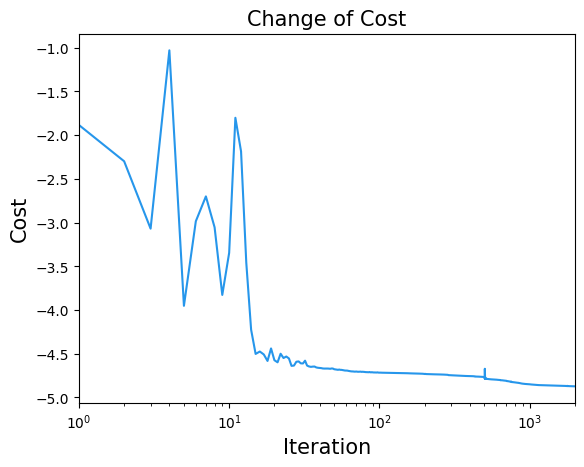

In [8]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

最適化されたパラメータが得られたら、QuriPartsの`create_qulacs_vector_sampler`を使用してパラメータ化された量子回路からサンプリングを行い、回路のカウントを取得します。

In [9]:
# 最適化済QAOA回路を実行する

sampler = create_qulacs_vector_sampler()
bounded_circuit = qp_circuit.bind_parameters(result.x)
qp_result = sampler(bounded_circuit, 1000)

In [10]:
bitcounts = {bin(i)[2:].zfill(qp_circuit.qubit_count): count for i, count in qp_result.items()}

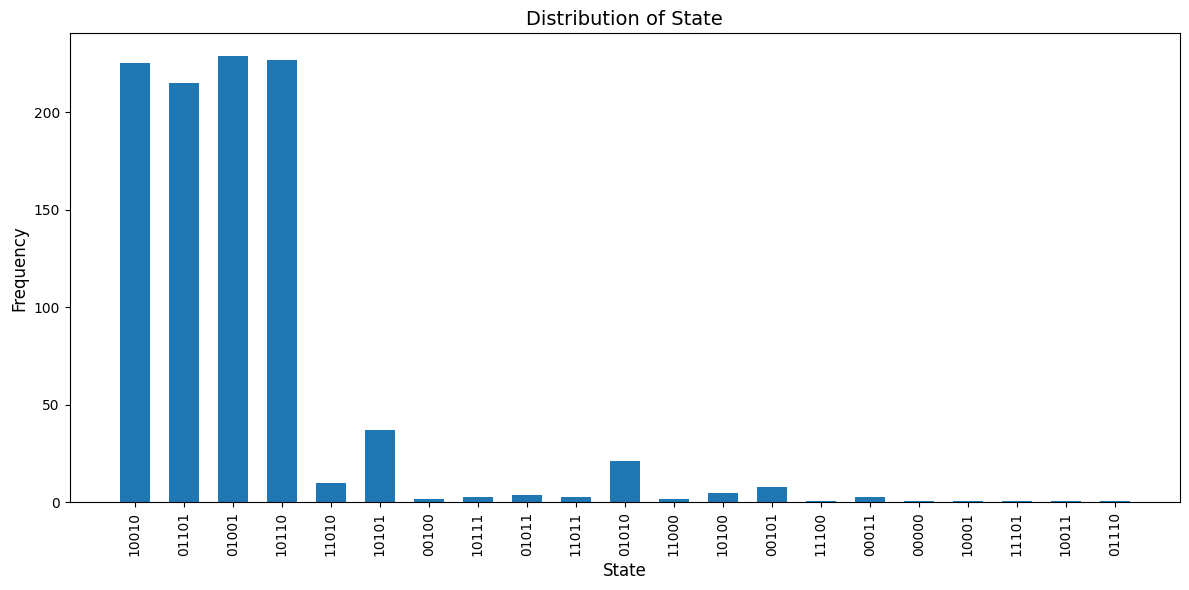

In [11]:
# プロット用のデータを用意する
keys = list(bitcounts.keys())
values = list(bitcounts.values())

# プロットする
plt.figure(figsize=(12, 6))
plt.bar(keys, values, width=0.6)
plt.xlabel("State", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of State", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

## 結果の評価  
前に得られた`qp_result`と`qubit_count`から、`qaoa_converter.decode`を用いてそれらをsamplesetに変換できます。sampleset実行可能な解のみを選択することができ、その後、目的関数値の分布を調べます。

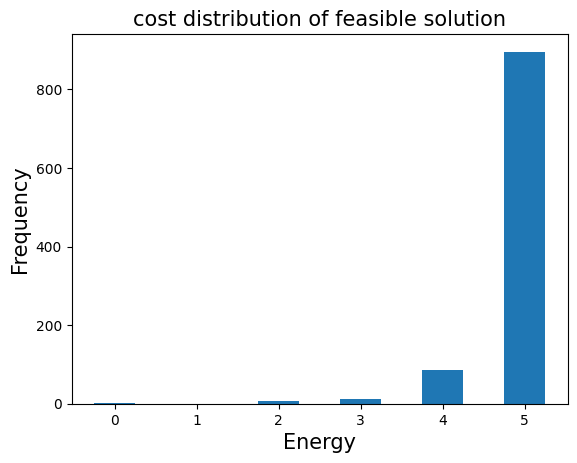

In [12]:
sampleset = qaoa_converter.decode(transpiler, (qp_result, qp_circuit.qubit_count))

feasible_ids = sampleset.summary.query("feasible == True").index
energies = []
frequencies = []
# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    if sample_id in feasible_ids:
        energy_freq[sample.objective] += 1

energies = list(energy_freq.keys())
frequencies = list(energy_freq.values())

plt.bar(energies, frequencies, width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()